In [78]:
import numpy as np

import pandas as pd

import pymc3 as pm

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
def create_windowed_data(data, window=5, look_ahead=1):
    """Create input and target data from a series given
    a window and look_ahead.
    """
    X = []
    y = []
    for t in range(len(data) - look_ahead):
        
        start = max(0, t-(window - 1))
        end = t + look_ahead
        
        windowed = data[start: end]
        if len(windowed) < window:
            
            mask = [
                np.nan for missing in range(window - len(windowed))
            ]
            windowed = np.concatenate(
                (mask, windowed)
            )

        X.append(
            windowed
        )
        y.append(
            data[end]
        )
    
    return np.array(X), np.array(y)

def build_expo_smooth_model(X, y, beta_kwargs):
    """Create exponential smoothing model using a window of 5.
    """
    with pm.Model() as model:

        alpha = pm.Beta(
            'alpha',
            **beta_kwargs
        )
        X_inputed = pm.Normal(
            'X_inputed', 
            mu=0, 
            sd=1, 
            observed=X
        )
        
        mu = pm.Deterministic(
            'mu',
            alpha*X_inputed[:, -1] + 
            alpha*(1-alpha) * X_inputed[:, -2] + 
            (alpha*(1-alpha)**2) * X_inputed[:, -3] + 
            (alpha*(1-alpha)**3) * X_inputed[:, -4] +
            (alpha*(1-alpha)**4) * X_inputed[:, -5]
        )
        sigma = pm.HalfNormal(
            'sigma',
            1
        )

        observed = pm.Normal(
            'observed_deaths',
            mu=mu,
            sigma=sigma,
            observed=y
        )
    
    return model

# Set Global Variables

In [80]:
target_years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
covid_deaths_2020 = 76453

# Reads Data

In [81]:
df = pd.read_csv('data//deaths_uk.csv')
df = df.rename(
    {
        'Number \r\nof deaths': 'n_deaths',
        'Year': 'year'
    },
    axis=1
)
df = df[['year', 'n_deaths']]
df = df.sort_values('year')
df['n_deaths'] = df['n_deaths'].str.replace(',', '', regex=False).astype(int)
df

,year,n_deaths
30,1990,564846
29,1991,570044
28,1992,558313
27,1993,578512
26,1994,551780
25,1995,565902
24,1996,563007
23,1997,558052
22,1998,553435
21,1999,553532


# Exploratory Visualization

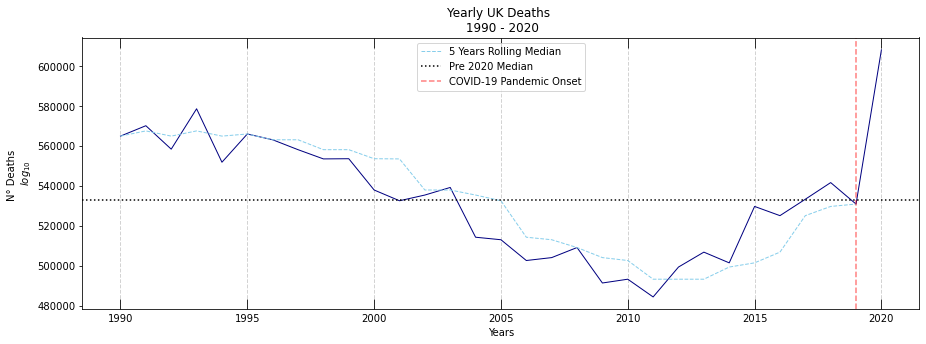

In [82]:
plt.figure(figsize=(15, 5))
plt.plot(
    df['year'].values,
    df['n_deaths'].values,
    linewidth=1,
    c='navy'
)
plt.plot(
    df[df['year'] != 2020]['year'].values,
    df[df['year'] != 2020]['n_deaths'].rolling(window=5, min_periods=1).quantile(0.5),
    linewidth=1,
    label='5 Years Rolling Median',
    linestyle='--',
    c='skyblue'
)
plt.axhline(
    df[df['year'] != 2020]['n_deaths'].quantile(0.5),
    linestyle=':',
    color='k',
    label='Pre 2020 Median'
)


for year in target_years:
    
    plt.axvline(
        year,
        color='lightgray',
        linestyle='--',
        linewidth=1,
        zorder=-1
    )

plt.xticks(target_years)
plt.tick_params(
    axis='x',
    direction='in',
    length=10.0,
    zorder=3,
    top=True
)
plt.axvline(
    2019,
    color='r',
    linestyle='--',
    alpha=0.5,
    label="COVID-19 Pandemic Onset"
)

plt.title("Yearly UK Deaths \n 1990 - 2020")
plt.xlabel("Years")
plt.ylabel("N° Deaths \n $log_{10}$")

plt.legend()
plt.show()

# Defining data for modelling

In [83]:
mean_data = df[df['year'] != 2020]['n_deaths'].mean()
sigma_data = df[df['year'] != 2020]['n_deaths'].std()

X_tr, y_tr = create_windowed_data(
    data=(df[df['year'] != 2020]['n_deaths'].values - mean_data) / sigma_data
)

# Instantiating and sampling from the model

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in X_inputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
C:\Users\PENTHO~1\AppData\Local\Temp/ipykernel_6976/4191052487.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, X_inputed_missing, alpha]


Sampling 4 chains for 4_000 tune and 3_000 draw iterations (16_000 + 12_000 draws total) took 114 seconds.


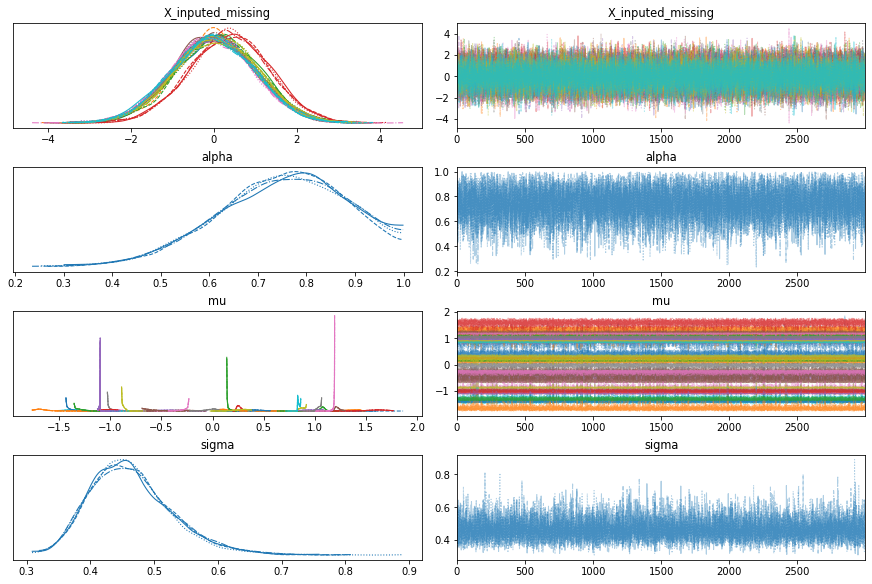

In [84]:
model = build_expo_smooth_model(
    X=X_tr,
    y=y_tr,
    beta_kwargs={
        'alpha': 1,
        'beta': 1
    }
)
with model:
    trace = pm.sample(
        tune=4000,
        draws=3000
    )
    pm.plot_trace(trace)
    ppc_tr = pm.sample_posterior_predictive(
        trace,
        var_names=['observed_deaths']
    )

# In and out of sample forecast

In [85]:
X_ts, y_ts = create_windowed_data(
    data=(df['n_deaths'].values - mean_data) / sigma_data
)

forecast_model = build_expo_smooth_model(
    X_ts, 
    y_ts,     
    beta_kwargs={
        'alpha': 1,
        'beta': 1
    }
)

with forecast_model:

    ppc_ts = pm.sample_posterior_predictive(
        trace,
        var_names=['observed_deaths']
    )
    
estimated_deaths = ppc_ts['observed_deaths']

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in X_inputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


# Forecast visualization

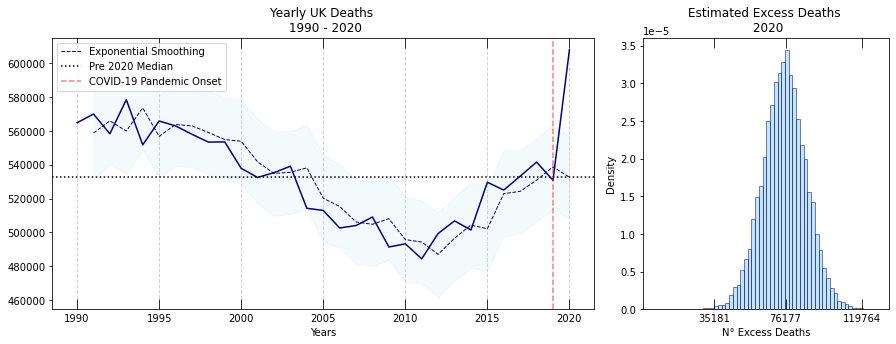

In [114]:
fig = plt.figure(figsize=(15, 5))
grid = gridspec.GridSpec(1, 3, figure=fig)

ax_ts = fig.add_subplot(grid[:, :-1])
ax_dist = fig.add_subplot(grid[:, -1])

ax_ts.plot(
    df['year'].values,
    df['n_deaths'].values,
    c='navy'
)

ax_ts.plot(
    df['year'].values[1:],
    ((estimated_deaths * sigma_data) + mean_data).mean(0),
    linewidth=1,
    c='navy',
    linestyle="--",
    label="Exponential Smoothing"
)
ax_ts.fill_between(
    df['year'].values[1:],
    np.percentile(((estimated_deaths * sigma_data) + mean_data), 2.5, axis=0),
    np.percentile(((estimated_deaths * sigma_data) + mean_data), 97.5, axis=0),
    linewidth=1,
    alpha=0.1,
    color='skyblue',
    zorder=-10
)
    
ax_ts.axhline(
    df[df['year'] != 2020]['n_deaths'].quantile(0.5),
    linestyle=':',
    color='k',
    label='Pre 2020 Median'
)


for year in target_years:
    
    ax_ts.axvline(
        year,
        color='lightgray',
        linestyle='--',
        linewidth=1,
        zorder=-1
    )

ax_ts.set_xticks(target_years)
ax_ts.tick_params(
    axis='x',
    direction='in',
    length=10.0,
    zorder=3,
    top=True
)
ax_ts.axvline(
    2019,
    color='r',
    linestyle='--',
    alpha=0.5,
    label="COVID-19 Pandemic Onset"
)

ax_ts.set_title("Yearly UK Deaths \n 1990 - 2020")
ax_ts.set_xlabel("Years")
plt.ylabel("N° Deaths \n $log_{10}$")

ax_dist.hist(
    df['n_deaths'].values[-1] - ((estimated_deaths[:, -1] * sigma_data) + mean_data),
    bins=60,
    color="skyblue",
    ec="navy",
    alpha=0.5,
    density=True
)

ax_dist.set_xticks(
    np.percentile(
        df['n_deaths'].values[-1] - ((estimated_deaths[-1] * sigma_data) + mean_data), 
        [2.3, 50, 97.7]
    )
)
ax_dist.tick_params(
    axis='x',
    direction='in',
    length=10.0,
    zorder=3,
    top=True
)


ax_dist.set_title("Estimated Excess Deaths \n 2020")
ax_dist.set_ylabel("Density")
ax_dist.set_xlabel("N° Excess Deaths")

ax_ts.legend()
plt.show()

In [101]:
np.max(df['n_deaths'].values[-1] - estimated_deaths[:, -1])

608003.9733915487

In [103]:
estimated_deaths[:, -1]

array([-0.09638708, -0.44008404,  0.62449446, ...,  0.36219628,
        0.79851197, -0.62042444])